# Zion Data Analysis Notebook

Defs, Imports, etc

In [1]:
import os, sys
from glob import glob
import time
from collections import UserDict, UserString
import numpy as np
import pandas as pd
from skimage.color import rgb2hsv
from skimage import filters, morphology, segmentation, measure
from scipy.optimize import nnls
from tifffile import imread, imwrite
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [11, 8]

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))
    

from ImageProcessing.ZionImage import ZionImage, create_labeled_rois, get_wavelength_from_filename, get_cycle_from_filename, get_time_from_filename, get_imageset_from_cycle
from ImageProcessing.ZionBaseCaller import crosstalk_correct, display_signals, create_phase_correct_matrix, base_call, add_basecall_result_to_dataframe, project_color
from ImageProcessing.ZionData import df_cols, extract_spot_data, csv_to_data, add_basecall_result_to_dataframe

### Give the notebook a directory of tiffs to work in and some parameters:

In [2]:
#input_dir_path = "C:\\Users\\ZacharyAugenfeld\\Documents\\ZionData\\20221129_1610_TS_0024_5Cycles_95Q7"
#input_dir_path = "C:\\Users\\ZacharyAugenfeld\\Documents\\ZionData\\S0063"
input_dir_path = "Z:\\GoogleData\\InstrumentData\\MK27_02\\20230419_2037_S0079_0001\\raws2"
#input_dir_path = "C:\\Users\\ZacharyAugenfeld\\Documents\\ZionData\\20230404_1527_S0070_0001\\raws"

# This parameter determines whether temporal difference images are used
useDifferenceImage = True

# This is the name of the UV channel
uv_wl = "365"

# This determines what type of background subtraction is used
'''Note: bgSubtract = True has not been tested'''
bgSubtract = False

# This is if the files are .tiff instead of .tif
useTiff = False

# This was used to help with file identification
#bTiff = False


## Step 1: Spot Detection

### Define parameters used in spot detection. 

When you run this cell, ROIs will be displayed. Verify you get the spots you want. (If not, adjust parameters here and re-run.)

Detecting ROIs using median=9, erode=30, dilate=30, scale=0.9
86 spot candidates found
removing spot 86 with area 1130 -- too small


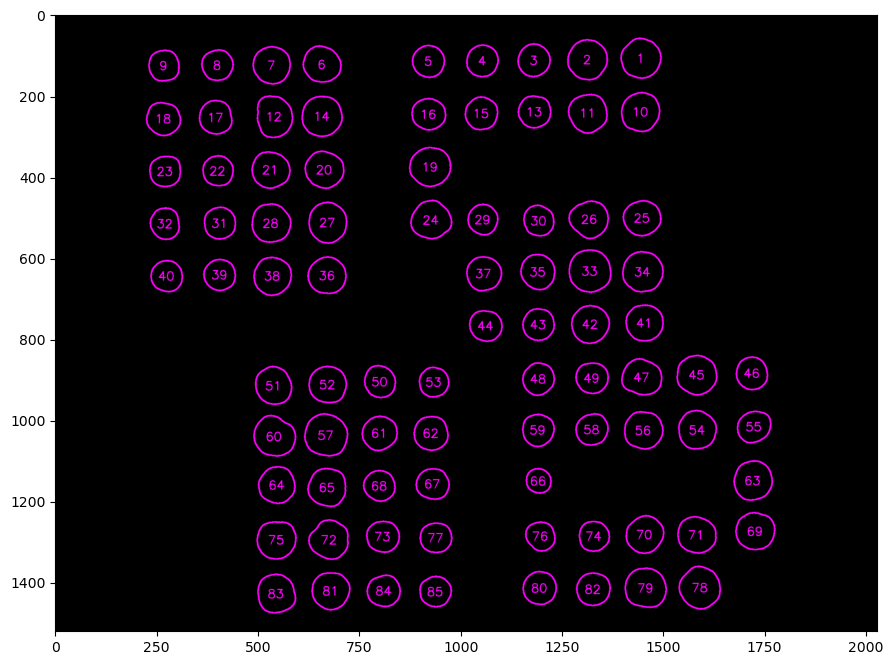

In [3]:
# This determines size of noise filter kernel (prob doesn't need to be changed much)
median_kernel_size = 9

# These tune spot size and how much spot border is included
erode_kernel_size = 30
dilate_kernel_size = 30

# This adjusts sensitivity for thresholding (should be close to 1)
threshold_scale = 0.9

# These are constraints on how large or small a spot could be
spotMinSize = 1200
spotMaxSize = None

# This is a list of RGB weights when turning the (UV) image to grayscale
rgb_weights = (0.4, 0.2, 0.1)
#rgb_weights = None

'''If roi_label_imagefile is set to None, spot detection will be performed.
   If it is set to a file, it will load spot ROIs and NOT run spot detection,
   and the above spot detection parameters will be ignored.'''

roi_label_imagefile = None
#roi_label_imagefile = "Z:\\GoogleData\\InstrumentData\\MK27_02\\20230419_2037_S0079_0001\\analysis\\jupyter\\RoiMap2.tif" #useful if already run
#roi_label_imagefile = os.path.join(input_dir_path, "roi_labels.tiff")

#### DO NOT EDIT BELOW THIS LINE ####
cycle1ImageSet = get_imageset_from_cycle(1, input_dir_path, uv_wl, False, useTiff=useTiff)

if roi_label_imagefile is not None:
    spot_labels = imread(os.path.join(input_dir_path, roi_label_imagefile))
else:
    _,spot_labels,_ = cycle1ImageSet.detect_rois( os.path.join(input_dir_path), median_ks=median_kernel_size, erode_ks=erode_kernel_size, dilate_ks=dilate_kernel_size, threshold_scale=threshold_scale, minSize=spotMinSize, maxSize=spotMaxSize, gray_weights=rgb_weights)

rois_img = create_labeled_rois(spot_labels, notebook=True)
#imwrite(os.path.join(input_dir_path, "rois_img.tif"), rois_img)
plt.imshow(rois_img)

#TODO fix other excitation images with ROI overlay (works on pi so condition off of notebook=True)

Now you can remove spots by listing their labels in list of exclusions below, or add spots by attaching a label image (eg an ROI map tif file from ImageJ).

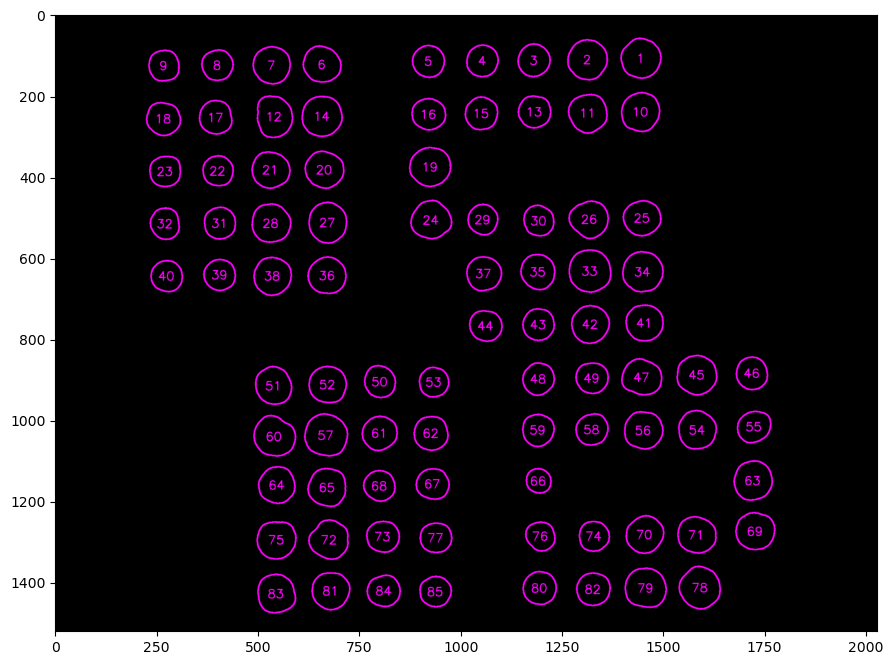

In [4]:
'''You can (and should) reorder the labels here.
    new_order is a lookup table (in python list form) whose values are old roi labels
    the indices of which are the new roi labels.
    In other words, it maps old roi labels to new roi labels.
    
    If you want to exclude an roi detected above, put its value in to_exclude below:
'''
#to_exclude = [12,27,23,44,45,63,81]
#new_order = [1,2,3,9,7,5,8,6,4,
#             19,14,18,15,11,17,16,12,13,10,
#             27,28,23,24,22,25,21,26,20,
#             33,37,34,36,29,35,32,30,31,
#             39,44,41,42,40,43,38,
#             53,45,54,52,46,50,49,47,51,48,
#             60,61,62,58,57,59,55,56,63,
#             67,71,70,65,69,66,68,64,
#             78,72,76,74,77,75,73,
#             80,79,82,81
#            ]
to_exclude=None
new_order=None


'''
Following to be used to add a few more manually segmented ROIs: 
'''
label_image_to_fuse = None
#label_image_to_fuse = "Roi Map.tif"

#### DO NOT EDIT BELOW THIS LINE ####
binary_img1 = spot_labels.astype(bool)
binary_img2 = imread(os.path.join(input_dir_path, label_image_to_fuse)).astype(bool) if label_image_to_fuse is not None else np.zeros_like(binary_img1)

spot_labels2 = measure.label(np.logical_or(binary_img1, binary_img2))
spot_labels3 = np.zeros_like(spot_labels2)
if new_order is not None:
    offset = 0
    for spot_label in new_order:
        if not spot_label in to_exclude:
            spot_labels3[spot_labels2==spot_label]=new_order.index(spot_label)+1-offset
        else:
            spot_labels3[spot_labels2==spot_label] = 0
            offset += 1
    rois_img = create_labeled_rois(spot_labels3, notebook=True)
    imwrite(os.path.join(input_dir_path, "rois_img.tif"), rois_img)
    plt.imshow(rois_img)
    spot_labels = spot_labels3
else:
    rois_img = create_labeled_rois(spot_labels2, notebook=True)
    imwrite(os.path.join(input_dir_path, "rois_img.tif"), rois_img)
    plt.imshow(rois_img)
    spot_labels = spot_labels2

imwrite(os.path.join(input_dir_path,"roi_labels.tiff"), spot_labels)

## Step 2: Define color dictionary

Either provide a file OR select spot (by label) for each base:

In [5]:
# For each base, provide purest spot (by label in image above): 
color_A_spots = [1]
color_C_spots = [2]
color_G_spots = [3]
color_T_spots = [4]

'''If basis_colors_file is set to None, spot detection will be performed.
   If it is set to a file, it will load color dictionary from file,
   ignoring the above basis color spots.'''

basis_colors_file = None
#basis_colors_file = os.path.join(input_dir_path, "M.npy")

# Define what spot is used as background/reference spot
# Note that this is only used if bgSubtract above is True
'''Note this has not been tested in notebook.'''
bg_spot = None

#### DO NOT EDIT BELOW THIS LINE ####
if basis_colors_file is not None:
    M = np.load(basis_colors_file)
else:
    M = np.zeros(shape=(3*(cycle1ImageSet.nChannels), 4))
    nSpots = np.max(spot_labels) # assumes we've already reindexed
    for base_spot_ind, base_spotlist in enumerate( (color_A_spots, color_C_spots, color_G_spots, color_T_spots) ):
        vec_list = []
        for base_spot in base_spotlist:
            vec_list.append( cycle1ImageSet.get_mean_spot_vector(spot_labels==base_spot) )
        #TODO: should we normalize the vector here?
        vec = np.mean(np.array(vec_list), axis=0)
        M[:,base_spot_ind] = vec
    np.save(os.path.join(input_dir_path, "M.npy"), M)
print(f"M = \n{M}")

M = 
[[ 4116.2156713   4333.7496136   4810.69268293  2664.09626955]
 [ 1672.70383382  8465.68385556  2022.2748924  12753.33012435]
 [ 1088.01710707  1088.2293101   2154.19454806  2410.00240674]
 [ 5531.35176417  4266.07840382  4909.2384505   9434.56718813]
 [ 2490.17992974  7857.82099199  2226.02008608 51516.55354994]
 [  830.24530319  1016.20570465  1577.29698709  9927.20738067]
 [ 2992.55720177 15827.54756218 12380.49239598  5060.27115925]
 [ 3655.62731022 32161.90304904 10119.72109039 29971.61492178]
 [  967.93523751  3596.7739216   2148.6553802   5768.09306057]
 [25133.6367802   4750.08683434 28260.03098996  4312.74127557]
 [ 9093.7455323   3156.07362653 10741.88120516  2699.5459286 ]
 [ 3000.49732702  1189.95756639  2153.44849354  3777.18090654]
 [49508.16923782  6542.41281439 14716.63472023  5917.40713999]
 [16487.12142966  1971.88028664  4577.46800574  1629.13437625]
 [ 5910.14388269   799.12097794  1214.65021521  2331.68391496]]


## Step 3: Extract spot data and write to CSV

In [7]:
''' This is total number of cycles included in database/csv.
    So, this should be 6 cycles if you want 5 cycles of basecalls.
'''
numCycles = 5

csvfile = os.path.join(input_dir_path, "basecaller_spot_data.csv")
with open(csvfile, "w") as f:
    f.write(','.join(df_cols)+'\n')
    
for new_cycle in range(1,numCycles+1):
    print(f"Extracting data from cycle {new_cycle}...")
    currImageSet = get_imageset_from_cycle(new_cycle, input_dir_path, uv_wl, useDifferenceImage, useTiff=useTiff)
    spot_data = extract_spot_data(currImageSet, spot_labels, csvFileName=csvfile)


Extracting data from cycle 1...
Extracting data from cycle 2...
Extracting data from cycle 3...
Extracting data from cycle 4...
Extracting data from cycle 5...


## Step 4: Perform base-calling

### First, determine signal pre-phase-correction:
Define number of cycles COLLECTED (phase-corrected output of base-caller will be 1 fewer):

In [8]:
#### DO NOT EDIT BELOW THIS LINE ####
# todo kinetics figure, similar to below
# generate pre-phase-correction histograms:
basecall_csv = csvfile

#todo: add option to use median instead of mean

basecall_pd = csv_to_data(basecall_csv)
basecall_data = basecall_pd.to_numpy()
signal_pre_basecall, spotlist, basecall_pd_pre = crosstalk_correct(basecall_pd, M, numCycles, cycle1ImageSet.wavelengths, factor_method="nnls")

#spotlist = sorted(spotlist)
basecall_pd_pre.to_csv(os.path.join(input_dir_path, "basecaller_output_data_pre.csv"))
#print(spotlist)

### Next, define p and q for phase correction matrix:

In [9]:
p = 0.015   # Probability that ZERO new base synthesized during a cycle (lagging)
q = 0.127   # Probability that TWO new bases synthesized during a cycle (leading)

#### DO NOT EDIT BELOW THIS LINE ####
Qinv = create_phase_correct_matrix(p,q,numCycles)
signal_post_basecall = np.transpose( (np.transpose(signal_pre_basecall, axes=(0,2,1)) @ Qinv)[:,:,:-1], axes=(0,2,1))
basecall_pd_post = add_basecall_result_to_dataframe(signal_post_basecall, basecall_pd)
basecall_pd_post.to_csv(os.path.join(input_dir_path, "basecaller_output_data_post.csv"))


### Now display results and write to report
Define report filename and number of rows in figure outputs.

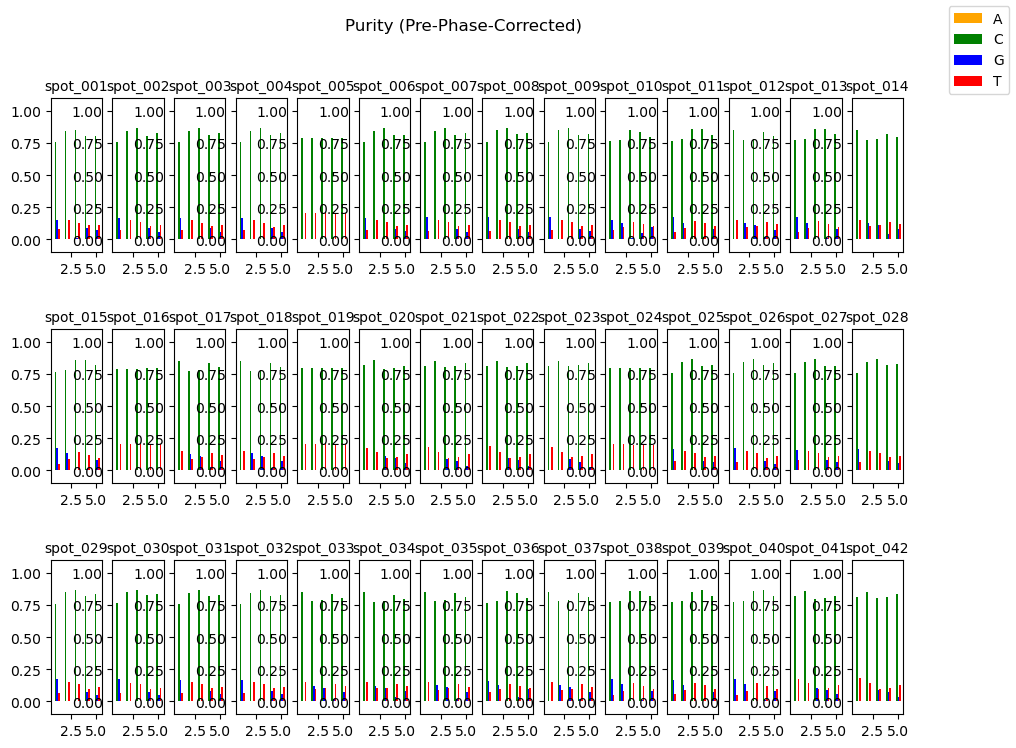

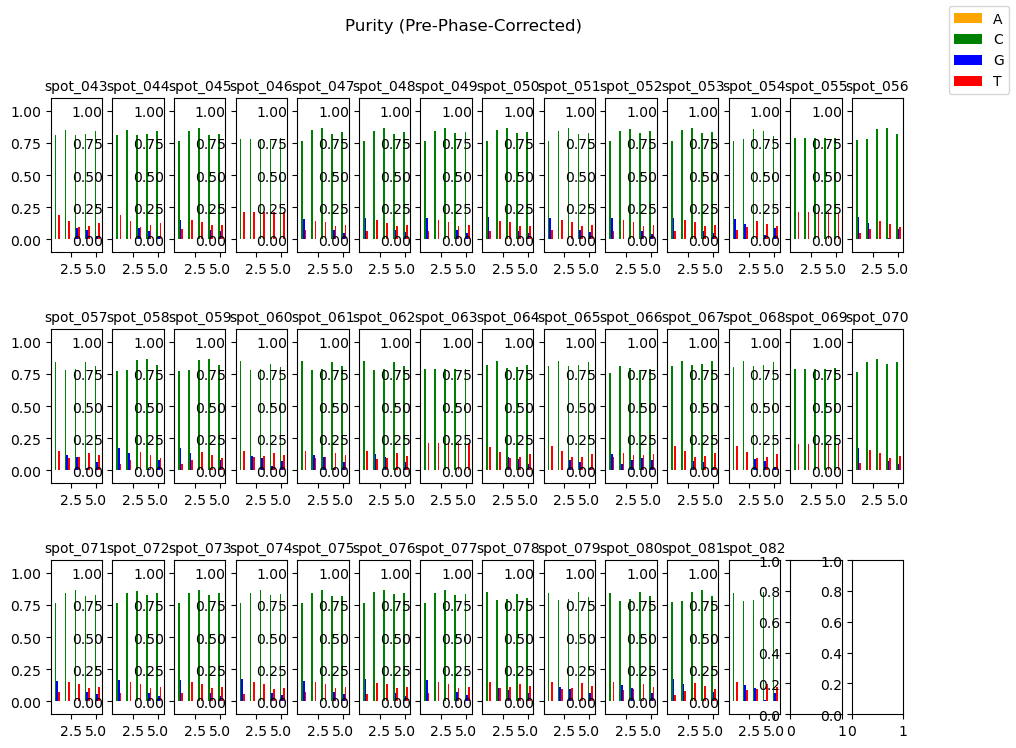

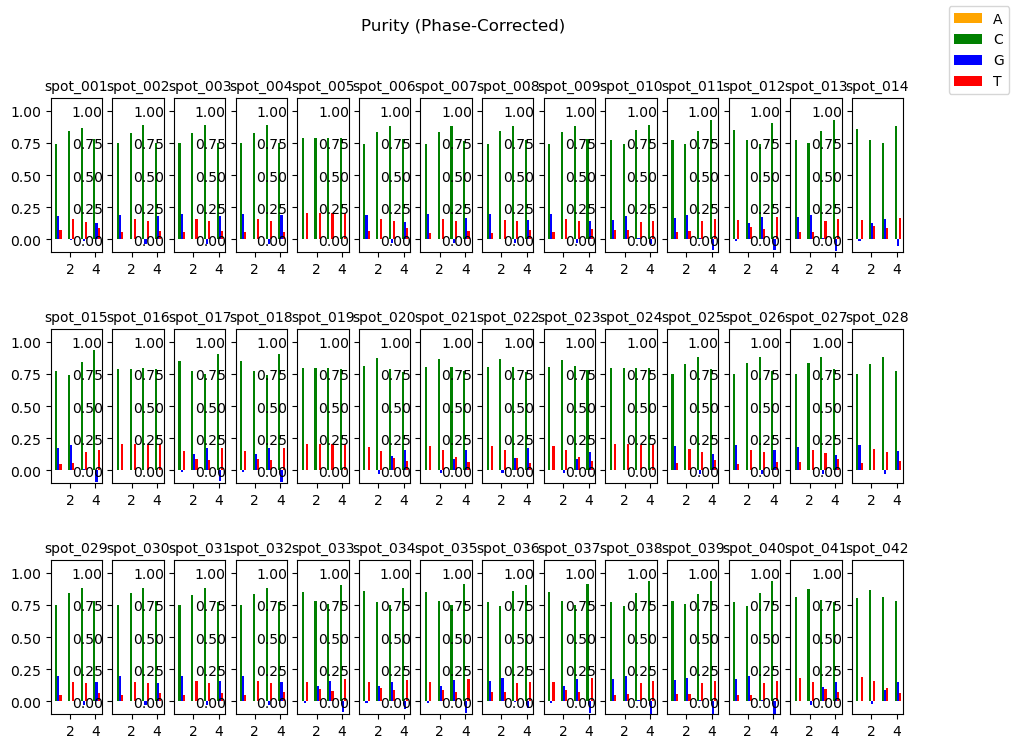

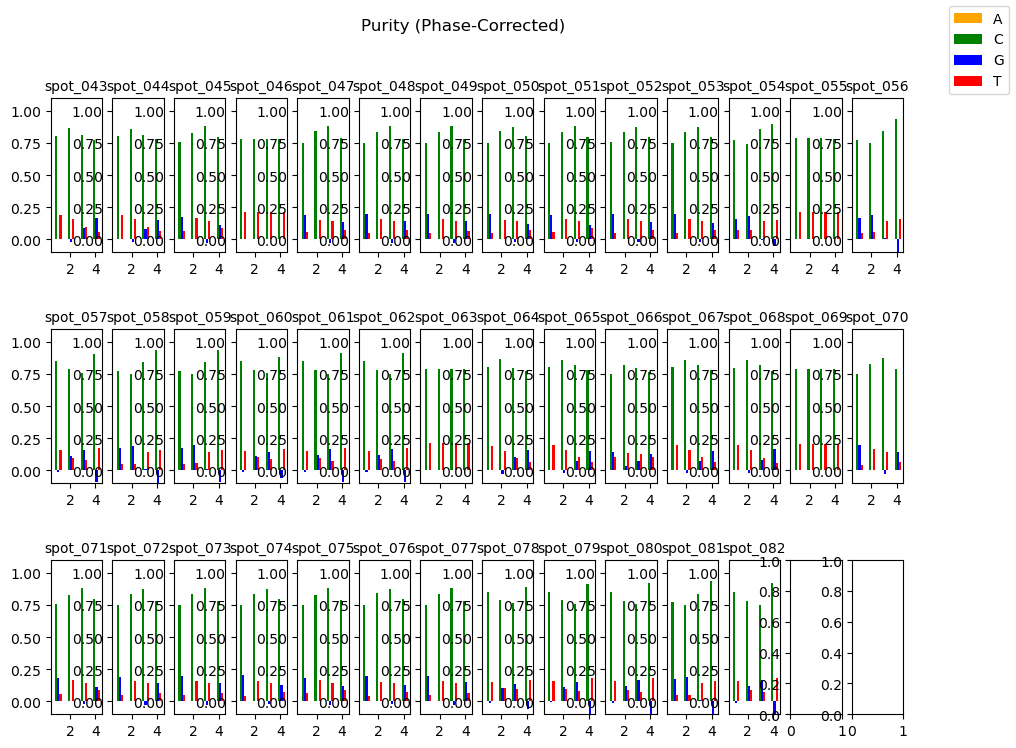

In [12]:
# You can name report file here:
reportfile = os.path.join(input_dir_path, "report.txt")

''' User settings for visualization
    If to_exclude_from_visualization is None, all spots are shown.
    figNumPages is the number of pages of figures.
    figNumRows is the number of rows of plots per page.
    
'''
to_exclude_from_visualization = [1,2,3,4,10,17,20,21,22,23,25,30,]#32,34,39,46,63,68,70,71,72,74,76,77,78,81,82,19,28,37,44,53,61,54,62,]
to_exclude_from_visualization = None

figNumRows = 3
figNumPages = 2
showLabels = False
showSignal = False


#### DO NOT EDIT BELOW THIS LINE ####

#TODO: spot name lookup table
spotlist_to_show = []
for s in range(1,83):
    if to_exclude_from_visualization is None or s not in to_exclude_from_visualization:
        spotlist_to_show.append(spotlist[s-1])
        
#When list of spots is given (instead of list of exclusions), use following line:
#spotlist_to_show = [spotlist[s-1] for s in spots_to_show]

f1, f2 = display_signals(signal_pre_basecall, spotlist, numCycles, show_spots = spotlist_to_show, numRows=figNumRows, numPages=figNumPages, preOrPost="pre", labels=False, noSignal = not showSignal)
f3, f4 = display_signals(signal_post_basecall, spotlist, numCycles-1, show_spots = spotlist_to_show, numRows=figNumRows, numPages=figNumPages, preOrPost="post", labels=False, noSignal = not showSignal)

for f_idx, f in enumerate(f1):
    f.savefig(os.path.join(input_dir_path, f"Purity Pre-Phase {f_idx+1}.png"), dpi=300)
for f_idx, f in enumerate(f2):
    f.savefig(os.path.join(input_dir_path, f"Signal Pre-Phase {f_idx+1}.png"), dpi=300)
for f_idx, f in enumerate(f3):
    f.savefig(os.path.join(input_dir_path, f"Purity Post-Phase {f_idx+1}.png"), dpi=300)
#for f_idx, f in enumerate(f4):
#    f.savefig(os.path.join(input_dir_path, f"Signal Post-Phase {f_idx+1}.png"), dpi=300)

#TODO add more metrics to report
#TODO package up as pdf?    

with open(reportfile, 'w') as f:
    if useDifferenceImage:
        print(f"Difference = Temporal", file=f)
    else:
        print(f"Difference = Dark", file=f)

    print(f"Median Filter Kernel Size = {median_kernel_size}", file=f)
    print(f"Erosion Kernel Size = {erode_kernel_size}", file=f)
    print(f"Dilation Kernel Size = {dilate_kernel_size}", file=f)
    print(f"Mean Threshold Scale Factor = {threshold_scale}", file=f)
    print(f"ROI labels at {os.path.join(input_dir_path, 'rois.jpg')}", file=f)
    print(f"'Cross-talk' matrix M = {M}", file=f)
    #todo list where output csv is?
    print(f"Pre-phase corrected Purity at {os.path.join(input_dir_path, 'Purity Pre-Phase.png')}", file=f)
    print(f"Pre-phase corrected Signal {os.path.join(input_dir_path, 'Signal Pre-Phase.png')}", file=f)
    print(f"Base-caller p = {p}", file=f)
    print(f"Base-caller q = {q}", file=f)
    print(f"Post-phase corrected Purity at {os.path.join(input_dir_path, 'Purity Post-Phase.png')}", file=f)
    print(f"Post-phase corrected Signal {os.path.join(input_dir_path, 'Signal Post-Phase.png')}", file=f)

In [ ]:
print(spotlist)